In [1]:
#| default_exp io

In [2]:
#| export

import numpy as np
from scipy import ndimage
from skimage import transform
from skimage.io import imread, imsave
import h5py
from typing import Iterable
import tifffile
import json
import os
from copy import deepcopy
import warnings
import functools

import igl

In [3]:
import matplotlib.pyplot as plt

In [4]:
#| export

def deprecated(func):
    """This is a decorator which can be used to mark functions
    as deprecated. It will result in a warning being emitted
    when the function is used."""
    @functools.wraps(func)
    def new_func(*args, **kwargs):
        warnings.simplefilter('always', DeprecationWarning)  # turn off filter
        warnings.warn("Call to deprecated function {}.".format(func.__name__),
                      category=DeprecationWarning,
                      stacklevel=2)
        warnings.simplefilter('default', DeprecationWarning)  # reset filter
        return func(*args, **kwargs)
    return new_func

## Basic I/O

In this notebook, we define a number of functions for image, mesh, and metadata loading and saving, and show how to use the with the data from the ``basics_example`` folder.

## Load and subsample data for segmentation

Let's load the dataset. We then enter the relevant metadata - the filename, resolution in microns, and how much we want to subsample for segmentation purposes.

In [5]:
#| export

def adjust_axis_order(image, channel_axis=None):
    """
    Adjust axis order of image (numpy array) so that the channel axis is axis 0. 
    
    If channel axis is not specified, it is infered as the axis with the smallest number of entries.
    If the image contains a single channel, this function adds a singleton dimension.
    Axis order is otherwise left unchanged. Image must have 3 axes (single channel volumetric)
    or four axes (multichannel volumetric). 
    
    Parameters
    ----------
    image: np.ndarray with 3 or 4 axes
        Input image.
    channel_axis: int or None, optional
        Channel axis
    
    Returns
    -------
    transposed image: np.ndarray with 4 axes
        Input image, channel now axis 0.
    """
    assert 2 < len(image.shape) <5 , "image must have 3 or 4 axes"
    if len(image.shape) == 3:
        return image[np.newaxis]
    if channel_axis is None:
        channel_axis = np.argmin(image.shape)
    return np.moveaxis(image, channel_axis, 0)

In [27]:
metadata_dict = {'filename': 'basics_example/basics_example',
                 'resolution_in_microns': (1, 0.36, 0.36), # you can typically get this from the .tif metadata
                 'subsampling_factors': (1, 1/3, 1/3),
                 'normal_offsets':np.linspace(-2, 2, 5) # normal offsets for map projection, in microns
                }

In [28]:
image = adjust_axis_order(imread(f"{metadata_dict['filename']}.tif"))
print("image shape:", image.shape) # image shape - spatial axes are in z-x-y order

image shape: (2, 26, 454, 511)


In [54]:
#| export

def subsample_image(image, subsampling_factors, use_block_averaging_if_possible=True):
    """
    Subsample (downscale) image by given factors.
    
    Reduce image size by given factors along each dimension. The subsampling_factors
    need to be _smaller than 1_. If the image is large,  subsampling can be performed
    by block averaging, which is a lot faster. In this case, you need to use inverse
    integer rescaling factors (e.g. 1/2, 1/3). If the number of pixels is not divisible
    by those factors, the subsampled image is padded by 0.
    
    Important: the chanel axis must be axis 0 (automatically done by adjust_axis_order)! 
    
    Parameters
    ----------
    image: np.ndarray
        Multichannel input image. Channel axis must be axis 0. (automatically done by adjust_axis_order).
    subsampling_factors : list or tuple of float or int
        Subsampling factors along each axis. A factor 1/2 will reduce image size by 2x along that axis.
    use_block_averaging_if_possible : bool, default True
        Use fast block averaging if subsampling_factors are inverses of integers.

    Returns
    -------
    subsampled_image: np.ndarray
        Subsampled imaged
    """
    inverse_factors_are_integer = all([np.round(1/x, decimals=5) == int(1/x) for x in subsampling_factors])
    if inverse_factors_are_integer and use_block_averaging_if_possible:
        inverse_factors = tuple([int(1/x) for x in subsampling_factors])
        return np.stack([transform.downscale_local_mean(chn, inverse_factors) for chn in image], axis=0)
    return np.stack([transform.rescale(chn, subsampling_factors, preserve_range=True) for chn in image], axis=0)

In [55]:
subsampled_image = subsample_image(image, metadata_dict['subsampling_factors'],
                                  use_block_averaging_if_possible=False)
print("subsampled image shape:", subsampled_image.shape)

subsampled image shape: (2, 26, 152, 171)


## Create 3d segmentation

Now create a 3d segmentation, in this case using ilatik. ilastik works best with input saved as `.h5` data sets. 

In [9]:
#| export

def normalize_quantiles_zstack(image, quantiles=(0.01, 0.99)):
    """
    Normalize an image by setting given quantiles to 0 and 1.
    
    Parameters
    ----------
    image : np.array
        Multi-dimensional image. First axis needs to be the channel axis.
    quantiles : tuple
        Image quantile to set to 0 and 1.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image
    """
    image_normalized = image - np.nanquantile(image, quantiles[0])
    image_normalized /= np.nanquantile(image_normalized, quantiles[1])
    image_normalized = np.nan_to_num(image_normalized)
    return image_normalized.astype(np.uint8)

In [10]:
#| export

def write_h5(filename, image, h5_dataset_name="image"):
    """Write image (numpy array) as .h5 file (e.g. as input for ilastik)."""
    with h5py.File(filename, "w") as f:
        f.create_dataset('image', data=image)
    return None

def read_h5(filename):
    """Read .h5 file (e.g. ilastik output) into numpy array. Loads alphabetically first entry in .h5."""
    with h5py.File(filename, "r") as f:
        arr = f[sorted(f.keys())[0]][()] 
    return arr

In [11]:
# we now save the subsampled image a .h5 file for input into ilastik for segmentation

write_h5(f"{metadata_dict['filename']}_subsampled.h5", subsampled_image)

In [12]:
# after creating an ilastik project, training the model, and exporting the probabilities, we load the segmentation

segmentation = read_h5(f"{metadata_dict['filename']}_subsampled-image_Probabilities.h5")
segmentation = segmentation[0] # select the first channel of the segmentation - it's the probablity a pixel
                               # is part of the sample
print("segmentation shape:", segmentation.shape)

segmentation shape: (26, 151, 170)


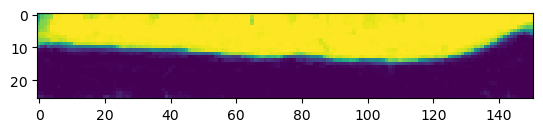

In [13]:
# look at the segmentation in a cross section

plt.imshow(segmentation[:,:,50], vmin=0, vmax=1)

## Meshing

We convert the segmentation into a triangular mesh using the marching cubes method, and save the mesh. We introduce a couple of functions for mesh io and mesh handling. We save all meshes in as wavefront `.obj` files (see [wikipedia](https://en.wikipedia.org/wiki/Wavefront_.obj_file)). In python, we represent missing entries (such as a vertex which doesn't have a normal by `np.nan`.

**Important convention** For sanities sake, we will always store all mesh coordinates in microns. This means rescaling appropriately after calculating the mesh from the 3d segmentation.

For reading, writing, holding, and handling `.obj` meshes, we will create a `ObjMesh` class. Basically, you can think of an `.obj` mesh as a _map_ between two meshes (the mesh in 3d, and its texture coordinates in 2d), defined on a per-face basis.

In [5]:
#| export

def flatten(lst, max_depth=1000, iter_count=0):
    """
    Flatten a list of lists into a list.

    Also works with inhomogeneous lists, e.g., [[0,1],2]. The argument
    depth determines how "deep" to flatten the list, e.g. with max_depth=1:
    [[(1,0), (1,0)]] -> [(1,0), (1,0)].

    Parameters
    ----------
    lst : list
        list-of-lists.
    max_depth : int, optional
        To what depth to flatten the list.
    iter_count : int, optional
        Helper argument for recursion depth determination.
    
    Returns
    -------
    iterator
        flattened list.
    """
    for el in lst:
        if (isinstance(el, Iterable) and not isinstance(el, (str, bytes))
                and iter_count < max_depth):
            yield from flatten(el, max_depth=max_depth,
                               iter_count=iter_count+1)
        else:
            yield el
            
def pad_list(lst, length=3, fill_value=np.nan):
    """Pad end of list with fill_value if shorter than desired length."""
    return lst + max([0, (length-len(lst))]) * [fill_value,]

def unique(sequence):
    """Create list of unique entries in sequence while preserving order"""
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def index_else_nan(arr, inds):
    """Return arr[inds], masked so that the result is np.nan wherever ind is nan"""
    if len(np.shape(inds)):
        inds = np.array(inds)
    mask = np.isnan(inds)
    masked_inds = np.copy(inds)
    masked_inds[mask] = 0
    masked_inds = masked_inds.astype(int)    
    selected = arr[masked_inds]
    selected[mask] = np.nan
    return selected

def invert_dictionary(my_map, assume_unique=False):
    """
    Invert key -> value map defined by a dictionary
    
    If assume_unique is True, key/value pairs are assumed to be unique.
    Else, a dictionary of list returned. Each entry is a list
    of keys that map to the given value.
    """
    if assume_unique:
        return {v: k for k, v in my_map.items()}
    inv_map = {}
    for k, v in my_map.items():
        inv_map[v] = inv_map.get(v, []) + [k]
    return inv_map

In [15]:
#| export

class ObjMesh:
    """
    Simple class for reading, holding, transforming, and saving 3d polygonal meshes in the .obj format.
    See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
    Attributes
        - vertices = [(x_0, y_0, z_0), ... ]
        - texture_vertices = [(u_0, v_0), ...] or None
        - normals = [(nx_0, ny_0, nz_0), ...] or None
        - faces = [f0, ...]
        - only_vertices = bool. 
    vertices, texture_vertices, normals are np.arrays, faces is a list of lists.
    Each face is either a list of vertex indices (if only_vertices is True), or, if the mesh
    has texture nformation, a list of vertex/normal index pairs. 
    Normals are always defined per-vertex, i.e. self.normals[i] is the normal vector at
    self.vertices[i].   Missing data is represented by np.nan.
    Faces can be any length (triangles, quads, ...). Indices start at 0!
    
    The method match_vertex_info can be used to match up vertices and normals to
    texture vertices based on the face connectivity as base points for interpolation.
    This sets the following attributes:
        - matched_vertices
        - matched_normals
    as np.array's
    """
    
    def __init__(self, vertices, faces, texture_vertices=None, normals=None, name=None):
        self.vertices, self.faces = (vertices, faces)
        self.texture_vertices, self.normals = (texture_vertices, normals)
        self.name = None

    @staticmethod
    def read_obj(filename):
        """
        Return vertices, texture vertices, normals, and faces from an obj file.

        Faces are lists of pairs vertex/texture vertex. If a certain vertex has no texture 
        associated to it, the entry is np.nan, else it is an index into the vertex/texture arrays
        (note: indices of returned faces start at 0!). See https://en.wikipedia.org/wiki/Wavefront_.obj_file.
        
        Intended for .obj files containing a single object only. Will emit a warning if multiple objects
        are detected.

        Parameters
        ----------
        filename : str
            filename
        Returns
        -------
        mesh: ObjMesh
        """
        def _str_to_int_or_nan(x):
            """Convert string to int or np.nan if string is empty"""
            if x == '':
                return np.nan
            return int(x)
        with open(filename, 'r') as f:
            lines = f.readlines()
        names = [ln.split()[1:] for ln in lines if ln.startswith("o ")]
        if len(names) > 1:
            warnings.warn(f"Warning: multiple meshes in .obj file", RuntimeWarning)
        name = None if len(names) == 0 else names[0]
        vs = np.array([ln.split()[1:] for ln in lines if ln.startswith("v ")]).astype(float)
        vts = np.array([ln.split()[1:] for ln in lines if ln.startswith("vt ")]).astype(float)
        ns = np.array([ln.split()[1:] for ln in lines if ln.startswith("vn ")]).astype(float)
        fs = [ln.split()[1:] for ln in lines if ln.startswith("f ")]
        fs = [[pad_list([_str_to_int_or_nan(y)-1 for y in x.split("/")], length=3, fill_value=np.nan)
               for x in f] for f in fs]
        if vts.shape == (0,) and ns.shape == (0,): # if there is no texture information
            fs = [[v[0] for v in f] for f in fs]
            mesh = ObjMesh(vs, fs, texture_vertices=None, normals=None, name=name)
        else: 
            # match up normals to vertices
            v_n_pairs = [np.nan for v in range(vs.shape[0])]
            for v, _, n in flatten(fs, max_depth=1):
                v_n_pairs[v] = n
            ns = index_else_nan(ns, np.array(v_n_pairs))
            ns = (ns.T/np.linalg.norm(ns, axis=1)).T
            fs = [[v[:2] for v in f] for f in fs]
            mesh = ObjMesh(vs, fs, texture_vertices=vts, normals=ns, name=name)
        return mesh
        
    def write_obj(self, filename, include_uv_and_normals=True):
        """
        Write mesh to .obj format.

        Can write texture coordinates and normals if included. 

        Parameters
        ----------
        filename : str
            filename to save to
        include_uv_and_normals : bool, default True
            include uv and normal information if available.
            
        Returns
        -------
        None

        """
        def _int_or_nan_to_str(x):
            """Convert int/nan to string. np.nan is converted to empty string"""
            if np.isnan(x):
                return ''
            return str(x)
        namelines = ["o {}\n".format(self.name)] if self.name is not None else []
        if self.only_vertices:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            flines = ["f {} {} {}\n".format(*[int(v+1) for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(flines)
        if not self.only_vertices and not include_uv_and_normals:
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            flines = ["f {} {} {}\n".format(*[int(v[0]+1) for v in fc]) for fc in self.faces]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(flines)
        if not self.only_vertices and include_uv_and_normals:
            assert all([len(v)==2 for v in flatten(self.faces, max_depth=1)]), "each vertex must have 2 indices"
            texture_vertices = [] if self.texture_vertices is None else self.texture_vertices
            vlines = ["v {} {} {}\n".format(*v) for v in self.vertices]
            vtlines = ["vt {} {}\n".format(*vt) for vt in texture_vertices]
            nlines = ["vn {} {} {}\n".format(*n) for n in self.normals] if self.normals is not None else []
            faces_with_normals = [[[v[0], v[1], v[0]] for v in fc] for fc in self.faces]
            flines = ["f {} {} {}\n".format(*["{}/{}/{}".format(*[_int_or_nan_to_str(ix+1) for ix in v])
                                              for v in fc]) for fc in faces_with_normals]
            with open(filename, 'w') as f:
                f.writelines(namelines)
                f.writelines(vlines)
                f.writelines(vtlines)
                f.writelines(nlines)
                f.writelines(flines)
        return None
    
    @property
    def only_vertices(self):
        if self.texture_vertices is None:
            assert all([not isinstance(v, Iterable) for v in flatten(self.faces, max_depth=1)]), \
                "If texture_vertices is None, faces must be lists of vertex indices only"
            return True
        return False
    
    @property
    def is_triangular(self):
        """Checks if mesh has triangular faces only."""
        return all([len(fc)==3 for fc in self.faces]) 
            
    @property
    def tris(self):
        """Get all 3d triangles in mesh as a numpy array. Entries are vertex indices."""
        if self.only_vertices:
            return np.array([fc for fc in self.faces if len(fc)==3])
        return np.array([[v[0] for v in fc] for fc in self.faces if len(fc)==3])
    
    @property
    def texture_tris(self):
        """Get all texture triangles in mesh as a numpy array. Entries are texture_vertex indices."""
        if self.only_vertices:
            return np.array([np.nan for fc in self.faces if len(fc)==3])
        return np.array([[v[1] for v in fc] for fc in self.faces if len(fc)==3])
    
    @property
    def vertex_textures(self):
        """Get array of vertex texture coordinates. If multiple textures per vertex are stored,
        the last one is returned."""
        if self.only_vertices:
            return np.nan*np.ones_like(self.vertices)[:,:2]
        if len(self.texture_vertices) == 0:
            return np.nan*np.ones_like(self.vertices)[:,:2]
        v_vt_pairs = [np.nan for v in range(self.vertices.shape[0])] # in case there are stray vertices w/out face
        for v, vt in flatten(self.faces, max_depth=1):
            v_vt_pairs[v] = vt
        return index_else_nan(self.texture_vertices, np.array(v_vt_pairs))
    
    def set_normals(self):
        """Recompute normals based on 3d positions. Only works for triangular meshes."""
        if not self.is_triangular:
            warnings.warn(f"Warning: mesh not triangular - normals may be incorrect", RuntimeWarning)
        normals = igl.per_vertex_normals(self.vertices, self.tris,)
        self.normals = (normals.T / np.linalg.norm(normals, axis=1)).T
        return None
        
    def get_uv_index_to_vertex_index_map(self):
        """Get map from texture vertex index to the corresponding 3d vertex index as a dictionary."""
        return {v[1]: v[0] for v in flatten(self.faces, max_depth=1) if not np.isnan(v[1])}
    
    def get_vertex_index_to_uv_index_map(self):
        """
        Get map from 3d vertex index to the corresponding UV vertex index as a dictionary.
        
        Note: each dict item is a list, since a 3d vertex can map to multiple UV vertices.
        """
        uv_to_vertex = self.get_uv_index_to_vertex_index_map()
        return invert_dictionary(uv_to_vertex, assume_unique=False)

        
    def get_uv_matched_vertex_indices(self):
        """
        Get an array of indices into 3d vertices that map them to the corresponding texture vertices.
        
        Useful for translating per-vertex data into per-texture-vertex data.
        """
        texture_vertex_dict = self.get_uv_index_to_vertex_index_map()
        return np.array([texture_vertex_dict[i] for i in range(self.texture_vertices.shape[0])])
        
    def match_vertex_info(self):
        """
        Match up 3d vertex coordinates and normals to texture vertices based on face connectivity.
        
        Compute matched_vertices and matched_normals, which are the 3d vertices and normals
        corresponding to each texture vertex. The resulting arrays have the shape
        (self.texture_vertices.shape[0], 3). If normal information does not exist for a given
        texture vertex, the entry is set to np.nan.
                    
        Returns
        -------
        None
        """
        
        assert not self.only_vertices and len(self.normals) > 0 and len(self.texture_vertices) > 0, \
            """Method requires texture or normal information"""
        matched_vertex_inds = self.get_uv_matched_vertex_indices()
        self.matched_vertices = self.vertices[matched_vertex_inds]
        self.matched_normals = index_else_nan(self.normals, matched_vertex_inds)
        return None

    def cut_along_seams(self):
        """
        Cut mesh along texture seams.

        Returns a new ObjMesh in which the topology of the vertices matches the topology of the texture vertices,
        by duplicating vertices along "seams" (i.e. which have multiple corresponding texture vertices),
        and discarding any vertices without texture coordinates.
        
        Returns
        -------
        ObjMesh

        """
        assert not self.only_vertices and len(self.normals) > 0 and len(self.texture_vertices) > 0, \
            """Method requires texture or normal information"""
        texture_vertex_dict = {v[1]: v[0] for v in flatten(self.faces, max_depth=1) if not np.isnan(v[1])}
        matched_vertex_inds = np.array([texture_vertex_dict[i] for i in range(self.texture_vertices.shape[0])])
        matched_vertices = self.vertices[matched_vertex_inds]
        matched_normals = index_else_nan(self.normals, matched_vertex_inds)
        cut_faces = [[[v[1], v[1]] for v in fc] for fc in self.faces if not any([np.isnan(v[1]) for v in fc])]
        return ObjMesh(matched_vertices, cut_faces, texture_vertices=self.texture_vertices,
                       normals=matched_normals, name=self.name)
        
    def apply_affine_to_mesh(self, trafo, update_matched_data=True):
        """
        Apply affine transformation to mesh.
        
        Rotate/shear and translate vertices, rotate/shear and renormalize normals,
        flip faces if transformation determinant is -1.

        Parameters
        ----------
        trafo : np.array of shape (4,4) or (3,3)
            Transformation matrix. If (4,4), it is interpreted as affine transformation.
        update_matched_data : bool, default True
            Update matched data

        Returns
        -------
        newmesh : ObjMesh
            Transformed mesh.

        """
        assert trafo.shape==(3,3) or trafo.shape==(4,4), "Transformation matrix must be 3*3 or 4*4"
        if trafo.shape == (3,3):
            trafo_matrix, trafo_translate = (trafo, np.zeros(3))
        elif trafo.shape == (4,4):
            trafo_matrix, trafo_translate = (trafo[:3,:3], trafo[:3,-1])
        newmesh = deepcopy(self)
        newmesh.vertices = self.vertices@trafo_matrix.T + trafo_translate
        if self.normals is not None:
            normals_transformed = self.normals@trafo_matrix.T
            newmesh.normals = (normals_transformed.T / np.linalg.norm(normals_transformed, axis=-1)).T
        if np.linalg.det(trafo_matrix) < 0:
            newmesh.faces = [fc[::-1] for fc in self.faces]
        if update_matched_data and not self.only_vertices:
            newmesh.match_vertex_info()
        return newmesh

In [17]:
#| export

def read_other_formats_without_uv(filename):
    """
    Return vertices and faces from a non-.obj mesh file format. file.

    Supported formats are: obj, off, stl, wrl, ply, mesh.
    Will NOT read in normals or texture coordinates. If you have texture
    coordinates, save your mesh as .obj. Will only return triangular faces.

    See https://libigl.github.io/libigl-python-bindings/igl_docs/#read_triangle_mesh.

    Parameters
    ----------
    filename : str
        filename
    Returns
    -------
    mesh: ObjMesh
        Only contains face and vertex info.
    """
    vs, fs = igl.read_triangle_mesh(filename)
    ns = igl.per_vertex_normals(vs, fs)
    return ObjMesh(vs, fs, texture_vertices=None, normals=ns, name=None)


### Test read/write 

In [30]:
read_other_formats_without_uv("wrapping_example/mixed_faces_example.obj")

  o Cube


In [31]:
%%time
mesh = ObjMesh.read_obj("drosophila_example/Drosophila_CAAX-mCherry_mesh_uv.obj")

CPU times: user 196 ms, sys: 1.8 ms, total: 198 ms
Wall time: 197 ms


In [32]:
mesh.vertices.shape, mesh.normals.shape, mesh.texture_vertices.shape

((8160, 3), (8160, 3), (8288, 2))

In [23]:
np.einsum('vi,vi->v', mesh.normals, igl.per_vertex_normals(mesh.vertices, mesh.tris))

array([0.99695517, 0.99865324, 0.98954003, ..., 0.99875341, 0.99958208,
              nan])

In [24]:
mesh.match_vertex_info()
mesh.matched_normals.shape, mesh.matched_vertices.shape

((8288, 3), (8288, 3))

In [25]:
# test this on an example
mesh_fname_ref = "registration_example/Drosophila_reference_preregistered.obj"
mesh_fname_data = "registration_example/Drosophila_CAAX-mCherry_mesh_remeshed.obj"

mesh = ObjMesh.read_obj(mesh_fname_ref)

In [26]:
%%timeit
mesh.match_vertex_info()

317 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Mesh cutting and gluing

The `cut_along_seams` method can be used to "cut" a mesh along its UV seams. This duplicates 3d vertices so that the 3d topology and the unwrapped UV topololy match. For example, if your UV map cuts your sphere mesh into a north and a south hemisphere for unwrapping, `cut_along_seams` will cut the mesh into two halves.

Conversely, `glue_seams` undoes the cutting by merging close vertices.

In [20]:
#| export

def glue_seams(mesh, decimals=None):
    """
    Merge close vertices.

    Useful to undo cutting of meshes along UV seams. Note: the exact order of vertices will
    not in general be recovered by glueing after cutting.

    Parameters
    ----------
    mesh : ObjMesh
    decimals : int or None, default 10
        Vertices whose positions agree up to 'decimals' decimals are merged. Note: you can use negative values.
        If None, estimate a value based on shortest edge length in the mesh (-2*log_10(minimum length))

    Returns
    -------
    glued_mesh : ObjMesh
        Mesh with merged vertices.

    """
    if decimals is None:
        ls = igl.edge_lengths(mesh.vertices, mesh.tris)
        decimals = np.round(-2*np.log10(ls.min())).astype(int)
    rounded_verts = np.round(mesh.vertices, decimals=decimals)
    unique_verts, index, inverse_index = np.unique(rounded_verts, axis=0, return_index=True, return_inverse=True)
    sort_index = index.argsort()
    sort_sort_index = sort_index.argsort()
    unique_verts = unique_verts[sort_index]
    glued_faces = [[[sort_sort_index[inverse_index[v[0]]], v[1]] for v in fc] for fc in mesh.faces]
    glued_mesh = ObjMesh(unique_verts, glued_faces, texture_vertices=mesh.texture_vertices,
                         normals=None, name=mesh.name)
    glued_mesh.set_normals()
    return glued_mesh

In [21]:
mesh = ObjMesh.read_obj("movie_example/initial_uv.obj")

In [23]:
mesh_cut = mesh.cut_along_seams()
glued_mesh = glue_seams(mesh_cut)

In [24]:
mesh.vertices.shape, mesh_cut.vertices.shape, glued_mesh.vertices.shape

((20212, 3), (20623, 3), (20212, 3))

In [25]:
glued_mesh.write_obj("movie_example/initial_uv_glued.obj")

## Create a 3d mesh of using the marching cubes method

In [29]:
level_set = mcubes.smooth(segmentation, method="gaussian") # converts segmentation into level set, with 0=surface
vertices, faces = mcubes.marching_cubes(level_set, 0)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

In [30]:
mesh = ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

In [19]:
#| export

def marching_cubes(volume, isovalue=0.5, sigma_smoothing=0):
    """
    Compute triangular mesh of isosurface using marching cubes as implemented by lib|igl.
    
    Parameters
    ----------
    volume : 3d np.array
        Array with scalar values from which to compute the isosurface.
    isovalue: float, default 0.5
        Isosurface to extract
    sigma_smoothing: float, default 0
        If >0, carry out Gaussian smoothing before marching cubes

    Returns
    -------
    vertices : np.array of shape (n_vertices, 3)
        Vertices
    faces : np.array of shape (n_faces, 3)
        Triangular faces (each face is a set of indices into the vertices array)
    """
    pts_grid = np.stack(np.meshgrid(*[np.arange(i) for i in volume.shape], indexing="ij"),
                        axis=-1).reshape(-1,3, order="F").astype(float)
    if sigma_smoothing>0:
        vals = ndimage.gaussian_filter(volume, sigma=sigma_smoothing).flatten(order="F")
    else:
        vals = volume.flatten(order="F")
    vertices, faces = igl.marching_cubes(vals, pts_grid, *volume.shape, isovalue)
    return vertices, faces

In [18]:
# now using igl

vertices, faces = marching_cubes(segmentation, isovalue=0.5, sigma_smoothing=3)

# EXTREMELY IMPORTANT - we now rescale the vertex coordinates so that they are in microns.
vertices_in_microns = vertices * (np.array(metadata_dict['resolution_in_microns'])
                                 /np.array(metadata_dict['subsampling_factors']))

mesh = ObjMesh(vertices_in_microns, faces)
mesh.name = "basics_example_mesh_marching_cubes_igl"
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes_igl.obj")

In [108]:
%%timeit
mesh.write_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

272 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
%%timeit
ObjMesh.read_obj(f"{metadata_dict['filename']}_mesh_marching_cubes.obj")

/tmp/ipykernel_50229/735907688.py:66: RuntimeWarning: Warning: multiple meshes in .obj file
  warnings.warn(f"Warning: multiple meshes in .obj file", RuntimeWarning)


161 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [110]:
%%time
## try a somewhat larger mesh with texture info etc

mesh = ObjMesh.read_obj("registration_example/Drosophila_reference.obj")

/tmp/ipykernel_50229/735907688.py:66: RuntimeWarning: Warning: multiple meshes in .obj file
  warnings.warn(f"Warning: multiple meshes in .obj file", RuntimeWarning)


CPU times: user 1.34 s, sys: 12.1 ms, total: 1.36 s
Wall time: 1.35 s


In [111]:
%%time

mesh.write_obj("registration_example/Drosophila_reference_test_write.obj")

CPU times: user 1.15 s, sys: 19.9 ms, total: 1.17 s
Wall time: 1.16 s


In [86]:
%%time
_ = igl.read_obj("registration_example/Drosophila_reference.obj")

CPU times: user 194 ms, sys: 16.2 ms, total: 211 ms
Wall time: 207 ms


  o embryo_rect


### Saving the results

We can now save the cartographic projections both as `.tif` stack for quantitative analysis, and as `.png`'s for visualization as mesh texture in blender. We will also save the metadata to a `.json` file

Annoyingly, we have to normalize our data and convert it to 8-bit to save it as png.

In [ ]:
#| export

def save_dict_to_json(filename, dictionary):
    """
    Save dictionary to .json file.
    
    Will automatically convert numpy arrays to lists for saving. If you get an error like "XXX is not JSON
    serializable", you need to ensure all your dictionary items are things that can be saved to text by json
    (strings, numbers, lists).
    
    Parameters
    ----------
    filename : str
        Filename to save to
    dictionary : dict
        Dictionary to save
    
    Returns
    -------
    None
    """
    serializable_dictionary = {key: val.tolist() if isinstance(val, np.ndarray) else val
                               for key, val in dictionary.items()}
    with open(filename, "w") as f:
        json.dump(serializable_dictionary, f)
    return None

In [ ]:
# save metadata
save_dict_to_json(f"{metadata_dict['filename']}_metadata.json", metadata_dict)

In [ ]:
#| export

def save_for_imageJ(filename, image, z_axis=None, channel_axis=None):
    """
    Save image as 32bit ImageJ compatible .tif file
    
    If channel_axis is not provided, it is inferred as the shortest axis.
    If z-axis is provided for a 4d array, it will be set as the default z-axis for ImageJ.
    """
    channel_axis = np.argmin(image.shape) if channel_axis is None else channel_axis
    if len(image.shape) == 3:
        transposed_image = np.moveaxis(image, channel_axis, 0)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'CYX'}, imagej=True,)
    elif len(image.shape) == 4:
        if z_axis is not None:
            transposed_image = np.moveaxis(image, (z_axis, channel_axis), (0,1))
        else:
            transposed_image = np.moveaxis(image, channel_axis, 1)
        tifffile.imwrite(filename, transposed_image.astype(np.float32),
                         metadata={'axes': 'ZCYX'}, imagej=True,)
    return None
    
def normalize_quantiles_for_png(image, quantiles=(0.01, 0.99)):
    """
    Normalize an image by setting given quantiles to 0 and 255 and converting to 8-bit, for saving as .png
    
    Also replaces nan by 0.
    
    Parameters
    ----------
    image : np.array
        Image (should be single-channel)
    quantiles : tuple
        Image quantile to set to 0 and 255.
    
    Returns
    -------
    image_normalized : np.array
        Normalized image, datatype np.uint8
    """
    image_normalized = image - np.nanquantile(image, quantiles[0])
    image_normalized /= np.nanquantile(image_normalized, quantiles[1])
    image_normalized = np.nan_to_num(np.round(np.clip(255*image_normalized, 0, 255)), nan=0)
    return image_normalized.astype(np.uint8)
    
    
def save_stack_for_blender(image, directory, normalization=(0.01, 0.99)):
    """
    Save multichannel volumetric image as series of grayscale .png images. Can normalize data if desired.
    
    This function necessarily converts the image to 8bit. Use a suitable normalization to ensure nothing 
    is lost.
    
    Parameters
    ----------
    image : 4d np.array
        Axis 0 is assumed to be the channel axis, axis 1 is the slicing axes, i.e. images will correspond to
        slices along axis 1.
    directory : str
        Path to save data to. Will create directory if it doesn't exist
    normalization : tuple of float, or callable
        Whether to normalize the image before saving it. If None, no normalization is performed. If a
        tuple is given, it will be interpreted as quantiles to set to 0 and 255, respectively (over the
        whole channel, not each slice). If a callable is provided, it will be applied to each channel.
        
    Returns
    -------
    None
    
    """
    directory = directory.removesuffix('/')
    if not os.path.exists(directory):
        os.makedirs(directory)
    for ic, ch in enumerate(image):
        if callable(normalization):
            ch_normalized = normalization(ch)
        if isinstance(normalization, tuple):
            ch_normalized = normalize_quantiles_for_png(ch, quantiles=normalization)
        for islc, slc in enumerate(ch_normalized):
            slc = np.stack(3*[slc], axis=-1).astype(np.uint8) # necessary for saving as png
            imsave(f'{directory}/channel_{ic}_slice_{str(islc).zfill(3)}.png', slc, check_contrast=False)
    return None

In [ ]:
# read the data so we can check the saving function
projected_data = adjust_axis_order(imread(f"{metadata_dict['filename']}_projected.tif"))
print("Image shape", projected_data.shape)

Image shape (2, 5, 256, 256)


In [ ]:
save_for_imageJ(f"{metadata_dict['filename']}_projected.tif", projected_data, z_axis=1)

In [ ]:
texture_path = f"{os.getcwd()}/{metadata_dict['filename']}_textures"
save_stack_for_blender(projected_data, texture_path, normalization=(0.01, 0.99))